In [1]:
#Preliminaries
import pandas as pd
import numpy as np
import itertools
from itertools import chain, combinations

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


from sklearn.model_selection import train_test_split
import math
import time

In [2]:
california = pd.read_csv('data/housing.csv')
california.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#Dummify categorical variables
california = pd.get_dummies(california)

#Remove observations that are NaN as these cannot be processed by our package
#Remember to reset the index - as you have removed some observations 
#and the influence diagnostics dataframe would not use the original dataset's index
california = california[np.isfinite(california).all(1)].reset_index(drop="True")

In [4]:
cols = california.columns.to_list()

#Target
target= california.median_house_value.values

#Features
features = [col for col in cols if col not in ['longitude', 'latitude','median_house_value']]
X = california[features].values

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size = 0.20, random_state = 5)

## Linear Regression

In [7]:
model_1 = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model_1 = model_1.summary()
print(print_model_1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2856.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:32:19   Log-Likelihood:            -2.0543e+05
No. Observations:               16346   AIC:                         4.109e+05
Df Residuals:                   16335   BIC:                         4.110e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.183e+04   5624.959      7.437      0.0

### To determine Influential Points, those with high residuals and high leverage, we can use the .get_influence() method

   dfb_const    dfb_x1    dfb_x2    dfb_x3    dfb_x4    dfb_x5    dfb_x6  \
0  -0.000846  0.002949  0.001171  0.000668 -0.001458 -0.000726 -0.000374   
1   0.001270 -0.005717  0.000420 -0.001990  0.001229  0.000565  0.003706   
2  -0.000527  0.000748 -0.000475  0.002679  0.001000 -0.002665  0.000079   
3  -0.005799  0.006221 -0.009443  0.009014  0.028819 -0.014865  0.017345   
4  -0.000182 -0.001843 -0.000074  0.000990 -0.000630 -0.000550  0.001627   

     dfb_x7    dfb_x8    dfb_x9   dfb_x10   dfb_x11   cooks_d  standard_resid  \
0  0.000231 -0.000827 -0.000080 -0.000082  0.000165  0.000004       -0.425729   
1  0.001022 -0.000364  0.000177  0.000115 -0.000286  0.000014        0.773165   
2  0.000230 -0.000984 -0.000053  0.000217  0.000224  0.000004       -0.465798   
3 -0.004756  0.000286 -0.000117 -0.000547 -0.000569  0.000123       -1.757706   
4 -0.001031  0.000114  0.000072  0.000242  0.000115  0.000006       -0.627119   

   hat_diag  dffits_internal  student_resid    dffits  


C:\Users\f.viernes\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Studentized Residuals')

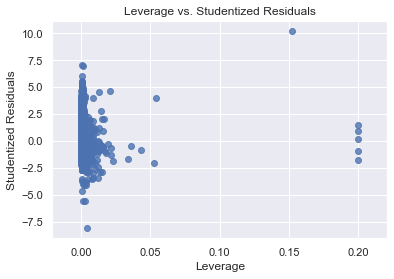

In [9]:
influence = model_1.get_influence()
inf_sum = influence.summary_frame()

print(inf_sum.head())


student_resid = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag


print ('\n')
print ('Leverage vs. Studentized Residuals')
sns.regplot(leverage, model_1.resid_pearson,  fit_reg=False)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')

Let us try to concatenate this dataframe with the target variable to determine the values of these most influential datapoints.

In [10]:
inf_sum.shape

(16346, 18)

In [11]:
training_set_target = pd.DataFrame(Y_train,columns=['median_house_value'])
concatenated_df =  pd.concat([training_set_target, inf_sum], axis = 1)
concatenated_df.describe()

,median_house_value,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,dfb_x6,dfb_x7,dfb_x8,dfb_x9,dfb_x10,dfb_x11,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
count,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,1.634600e+04,1.634600e+04,1.634600e+04,1.634600e+04,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000
mean,206768.320445,-0.000002,0.000002,-0.000008,0.000003,0.000049,-0.000015,0.000004,-0.000002,-0.000001,1.426915e-07,2.340178e-07,-5.972171e-07,2.015782e-04,0.000042,0.000673,0.000233,0.000078,0.000235
std,115191.912826,0.011614,0.009161,0.012812,0.011295,0.038010,0.016906,0.012970,0.011469,0.011350,1.143738e-02,1.128944e-02,1.133515e-02,1.447279e-02,1.000783,0.003872,0.049184,1.000973,0.049292
min,14999.000000,-0.880056,-0.165642,-0.904544,-0.395635,-0.078214,-1.758262,-0.480492,-0.812651,-0.815375,-9.613747e-01,-7.887202e-01,-7.988979e-01,1.325814e-13,-8.108982,0.000142,-0.963427,-8.125104,-0.963507
25%,120000.000000,-0.000934,-0.002634,-0.001666,-0.000928,-0.001665,-0.001053,-0.001307,-0.000606,-0.000385,-7.059267e-05,-3.320904e-04,-2.129184e-04,1.951201e-06,-0.612313,0.000278,-0.011893,-0.612301,-0.011893
50%,179800.000000,-0.000032,-0.000134,-0.000081,0.000119,-0.000067,0.000005,0.000108,0.000006,0.000024,6.954673e-06,2.143810e-05,2.328844e-05,9.776822e-06,-0.151278,0.000395,-0.002844,-0.151273,-0.002843
75%,264100.000000,0.000654,0.002149,0.001122,0.001493,0.000994,0.001201,0.002017,0.000456,0.000339,1.039114e-04,4.241813e-04,2.991959e-04,3.709936e-05,0.419763,0.000641,0.008684,0.419752,0.008684
max,500001.000000,0.768428,0.280493,0.266174,0.704056,4.568563,0.418191,0.585581,0.947184,0.948049,8.276262e-01,9.222524e-01,9.309935e-01,1.844636e+00,11.089842,0.200214,4.704852,11.131485,4.722520


### IDENTIFYING OUTLIERS

As we have identified outliers as having high residuals, we can view this using the summary table we have generated using the get_influence().

Quick note: A studentized residual is a quotient resulting from the division of the observation's residual over its estimated standard deviation. In a way, it is kind of a student's t-statistic, with the estimate of error varying between points. This is a very popular technique in outlier detection.

Generally, sources agree that observation with an absolute value of 3 on the studentized residual is considered unusual and is, therefore, an outlier. However, you may want to be more aggressive and set it to something lower than 3.

In [34]:
studentized_resids =  concatenated_df.student_resid
#Print the median house value of the outliers
print(concatenated_df.median_house_value[abs(studentized_resids) > 2])

19       325000.0
44       418500.0
69        75700.0
131      402900.0
201      500001.0
           ...   
16275    350000.0
16279    484700.0
16282    500001.0
16307    500001.0
16327    450000.0
Name: median_house_value, Length: 864, dtype: float64


In [13]:
#Highest Negative Residuals
studentized_resid_sort = concatenated_df.sort_values(by = 'student_resid')
print ('*'*20 + ' Most Negative Residuals ' + '*'*20)
print (studentized_resid_sort.head())
print ('\n')

#Highest Positive Residuals
print ('*'*20 + ' Largest Positive Residuals ' + '*'*20)
print (studentized_resid_sort.tail())
print ('\n')

******************** Most Negative Residuals ********************
       median_house_value  dfb_const    dfb_x1    dfb_x2    dfb_x3    dfb_x4  \
14120            131300.0   0.137867 -0.165642  0.266174 -0.184090 -0.066068   
9348             112500.0   0.058398 -0.093595  0.099438 -0.070943 -0.022524   
210              112500.0   0.063143 -0.035184  0.176874 -0.100819 -0.042439   
4349              67500.0   0.032512 -0.069736  0.044800 -0.037317 -0.009298   
6006             350000.0   0.024845  0.062603  0.140413 -0.084800 -0.031771   

         dfb_x5    dfb_x6    dfb_x7    dfb_x8    dfb_x9   dfb_x10   dfb_x11  \
14120  0.061480 -0.480492  0.028390 -0.005476  0.007607  0.049766  0.034972   
9348   0.027176 -0.187026  0.007197 -0.002595  0.004051  0.022518  0.014372   
210    0.022988 -0.285662  0.025167 -0.015986  0.002666  0.024019  0.019998   
4349   0.019600 -0.090810  0.000264 -0.001619  0.002969  0.013405  0.007524   
6006   0.028019 -0.221317  0.008151 -0.000567 -0.000279  0

The NaN in the positive residuals are really huge number divided by 0 because of the process known as deletion residuals, or externally Studentized residuals.

A really nice explanation can be found here: https://stats.stackexchange.com/questions/123368/studentized-residuals-undefined

Now, that we have identified observations that have high residuals or outliers, then we can apply a criterion to determine observations with high leverage

In [14]:
#Number of observations
n = california.shape[0]

#Predictors
k = california[features].shape[1]

#Leverage
cutoff_leverage = ((2*k)+2)/n


In [15]:
leverage = concatenated_df.hat_diag

leverage_sort = concatenated_df.sort_values(by = 'hat_diag', ascending = False)
print ('*'*20 + ' Highest Leverage Data Points ' + '*'*20)
print (leverage_sort.head())

******************** Highest Leverage Data Points ********************
       median_house_value  dfb_const    dfb_x1    dfb_x2    dfb_x3    dfb_x4  \
12948            287500.0  -0.464463  0.012594 -0.001053  0.010163  0.001402   
6311             450000.0   0.768428 -0.020132 -0.005890  0.006921 -0.000278   
1061             300000.0  -0.880056 -0.017889 -0.000154 -0.015814 -0.003926   
4198             414700.0   0.111228  0.002190 -0.000120  0.000360  0.000183   
15369            450000.0   0.470788  0.006646  0.002987 -0.003779 -0.001248   

         dfb_x5    dfb_x6    dfb_x7    dfb_x8    dfb_x9   dfb_x10   dfb_x11  \
12948 -0.008966  0.003788  0.490088  0.491568 -0.499307  0.475715  0.481708   
6311  -0.004341 -0.002934 -0.812651 -0.815375  0.827626 -0.788720 -0.798898   
1061   0.016330 -0.008365  0.947184  0.948049 -0.961375  0.922252  0.930993   
4198  -0.000076  0.000523 -0.119664 -0.119733  0.121457 -0.116517 -0.117608   
15369  0.002492 -0.000949 -0.503760 -0.504442  0.5119

In [16]:
#Print the high leverage data points
print(concatenated_df.median_house_value[abs(leverage) > cutoff_leverage])

12       147800.0
36       500001.0
39       184500.0
92        66600.0
100      141800.0
           ...   
16308    187800.0
16313    116600.0
16323    356100.0
16327    450000.0
16331    500001.0
Name: median_house_value, Length: 1012, dtype: float64


## Now making sense of these information.

Some sources would agree that influential data points are both outliers and have high leverage. And we can implement this for this exercise, but in reality, even just qualifying as an outlier or high leverage may be enough for an observation to be an influential point.

In [17]:
#Merge the observations that are outliers and have high leverage
outliers = pd.DataFrame((concatenated_df.student_resid[abs(studentized_resids) > 3]))
high_leverage = pd.DataFrame((concatenated_df.hat_diag[abs(leverage) > cutoff_leverage]))

#Influential Dataset
influential_points =pd.merge(outliers,high_leverage, left_index=True, right_index=True)
display(influential_points)

,student_resid,hat_diag
210,-5.573300,0.002908
246,4.128780,0.054392
1452,-3.426941,0.012196
1493,-3.769600,0.003537
2292,4.012838,0.008396
2509,3.807949,0.001262
2551,11.131485,0.152533
2567,3.085750,0.001376
2750,3.422641,0.001261
2964,4.089827,0.001660


### VISUALIZATION TO SPOT INFLUENTIAL DATAPOINTS

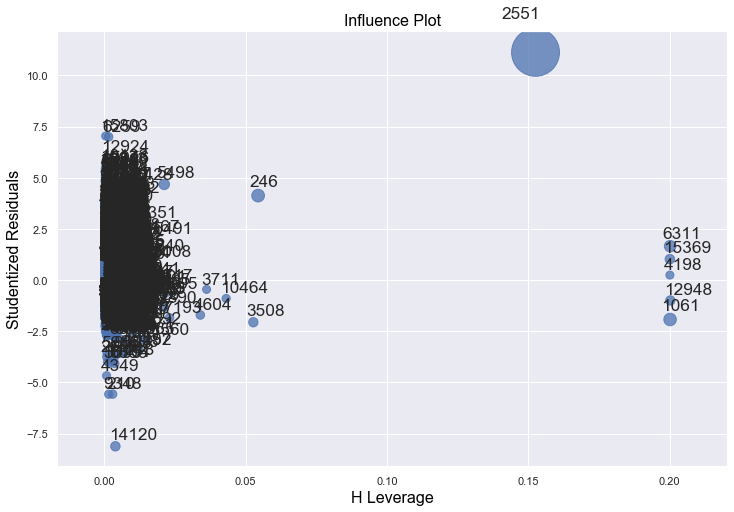

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model_1, ax= ax, criterion="cooks", alpha = 0.5)

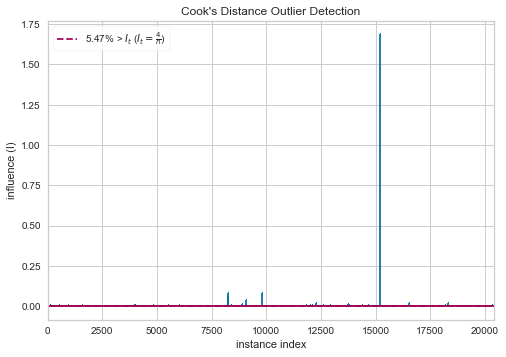

In [25]:
from yellowbrick.regressor import CooksDistance

#Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X,target)
visualizer.show();

We see that any observations that extend above the red line are influential datapoints.

The yellowbrick graph we generated used Cook's distance as a measure of overall influence. The other one used as a measure of overall influence is DFFITS (Difference in fits).
Cook's distances are nonnegative values and the higher they are, the more influential the observation is. 
The common cutoff used by most is three times the mean of the dataset's Cook's D in order for an observation to be classified as influential.

In [19]:
cutoff_cooks =(concatenated_df.loc[:,"cooks_d"].mean())*3
outliers_2 = pd.DataFrame((concatenated_df.cooks_d[abs(concatenated_df.cooks_d) > cutoff_cooks]))
display(outliers_2)

,cooks_d
12,0.000714
19,0.000719
210,0.007536
246,0.081632
313,0.000771
...,...
16080,0.000644
16089,0.000898
16099,0.000614
16257,0.001826


For DFFITS, the conventional cutoff value uses the same variables in the determination of cutoff of leverage we had earlier but using this formula:

In [20]:
#Cutoff for DFFITS
cutoff_dffits = 2* math.sqrt(k/n)
print(concatenated_df.dffits[abs(concatenated_df.dffits) > cutoff_dffits])

12      -0.092554
19       0.092889
44       0.082350
66       0.048494
69      -0.058700
           ...   
16282    0.072850
16287   -0.056974
16292    0.051807
16313   -0.073537
16327    0.193016
Name: dffits, Length: 1116, dtype: float64


Unlike Cook's distances, dffits can either be positive or negative. With a "0" value, the point lies exactly on the regression line.


In [21]:
outliers_3 = pd.DataFrame((concatenated_df.dffits[abs(concatenated_df.dffits) > cutoff_dffits]))
outliers_3.head()

,dffits
12,-0.092554
19,0.092889
44,0.082350
66,0.048494
69,-0.058700


### DFBETAS
While dffits and Cook's distance measures the general influence of an observation, dfbetas measure the influence of an observation brought about by a specific variable. As you can see, this is quite useful for multiple linear regression models.

In [33]:
#Variables for our plots later

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080']

markers = ['o','v', '^', 'p', '_', '+',
          'd', 'h', '*','|', 's']

dfbetas = [x for x in concatenated_df.columns.to_list() if ('dfb' in x)]

dfbeta_cutoff =  2/(n)**(0.5)
dfbeta_cutoff

0.013991488767839764

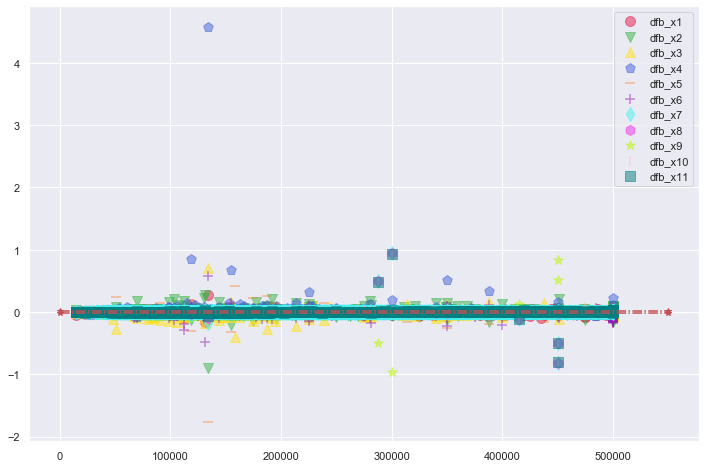

In [23]:
fig,ax = plt.subplots(figsize=(12,8))

for i in range(len(dfbetas)):
    ax.scatter(concatenated_df.median_house_value, 
               concatenated_df[dfbetas[i]], 
               color = colors[i], 
               marker = markers[i],
              label = dfbetas[i],
                alpha=0.5,
              s=100)
    ax.legend(loc='best')
    
plt.plot((0, 550000), (dfbeta_cutoff, dfbeta_cutoff), '-.r*')
plt.plot((0, 550000), (-dfbeta_cutoff, -dfbeta_cutoff), '-.r*')

We see that any observations that extend above the red line are influential datapoints.

## IMPROVING THE REGRESSION MODEL

Now that we have information on the possible influential data points, let us remove them and try to improve the predictive capacity of our models

In [26]:
#Influential Datapoints that we manually identified as both Outliers and have High Leverage
index_1 = outliers.index.to_list()

#Outliers Identified Using Cooks Distances
index_2 = outliers_2.index.to_list()

#Outliers Indentidied Using DFFITS
index_3 = outliers_3.index.to_list()

In [27]:
indices = [index_1,index_2, index_3]

for i in range(len(indices)):
    X = california[features].drop(indices[i]).values
    y = california['median_house_value'].drop(indices[i]).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)
    model= sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    print(model.summary())
    print(f'The R-squared for the model after removing influential points from {i} is {round(model.rsquared,3)}')
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2847.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:38:22   Log-Likelihood:            -2.0287e+05
No. Observations:               16141   AIC:                         4.058e+05
Df Residuals:                   16130   BIC:                         4.059e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.775e+04   7028.541      6.794      0.0